# Movie Recommendation System

## Abstrict
This project aims to construct a movie recommendation system using a dataset sourced from Kaggle [Movie Recommendation System](https://www.kaggle.com/datasets/parasharmanas/movie-recommendation-system/data). We will explore the construction of both supervised and unsupervised models to determine the optimal approach. Through rigorous evaluation techniques, the most effective model will be selected for recommendation purposes.

## Install and import necessary libraries

In [1]:
!pip install scikit-surprise

In [2]:
import itertools
import numpy as np
import pandas as pd
from surprise import accuracy
from collections import defaultdict
from surprise.model_selection import cross_validate
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import NMF

## Exploratory Data Analysis (EDA) and Data Preprocessing

### Load the data and check the basci information

In [3]:
# Load data
movies_df = pd.read_csv("/content/movies.csv")
ratings_df = pd.read_csv("/content/ratings.csv")

# Display basic information about the datasets
print("Movies Dataset:")
print(movies_df.info())
print(movies_df.shape)
print(movies_df.head())

print("\nRatings Dataset:")
print(ratings_df.info())
print(ratings_df.shape)
print(ratings_df.head())

Movies Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB
None
(62423, 3)
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Ratings Dataset:
<class 'pand

### Check for missing values

In [4]:
print("\nMissing Values in Movies Data:")
print(movies_df.isnull().sum())

print("\nMissing Values in Ratings Data:")
print(ratings_df.isnull().sum())


Missing Values in Movies Data:
movieId    0
title      0
genres     0
dtype: int64

Missing Values in Ratings Data:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


### Check for outliers in ratings

In [5]:
print(ratings_df.describe())

             userId       movieId        rating     timestamp
count  2.500010e+07  2.500010e+07  2.500010e+07  2.500010e+07
mean   8.118928e+04  2.138798e+04  3.533854e+00  1.215601e+09
std    4.679172e+04  3.919886e+04  1.060744e+00  2.268758e+08
min    1.000000e+00  1.000000e+00  5.000000e-01  7.896520e+08
25%    4.051000e+04  1.196000e+03  3.000000e+00  1.011747e+09
50%    8.091400e+04  2.947000e+03  3.500000e+00  1.198868e+09
75%    1.215570e+05  8.623000e+03  4.000000e+00  1.447205e+09
max    1.625410e+05  2.091710e+05  5.000000e+00  1.574328e+09


### Check the balance of the data.


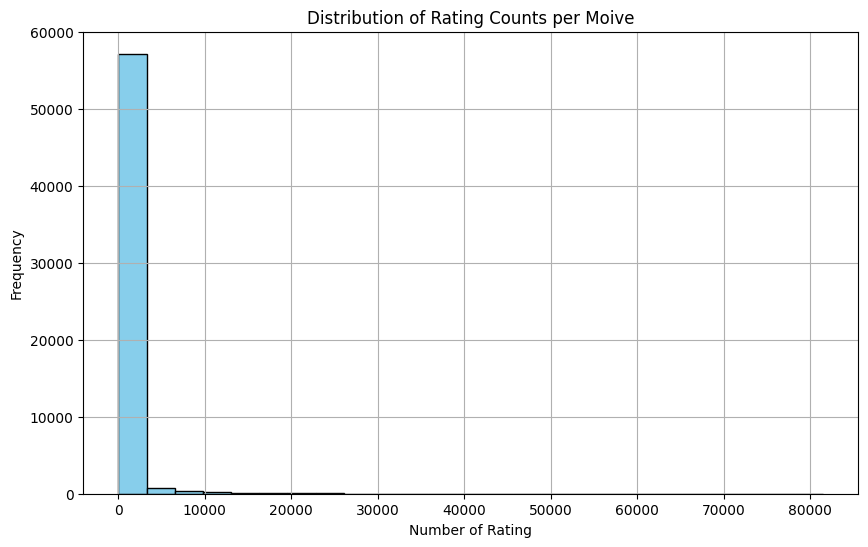

In [6]:
# Merge the movies_df and ratings_df on 'movieId'
merged_df = pd.merge(ratings_df, movies_df, on='movieId')

# Calculate the count of ratings for each moive
rating_counts = merged_df.groupby('title')['rating'].count()

# Plot a histogram of rating counts
plt.figure(figsize=(10, 6))
plt.hist(rating_counts, bins=25, color = 'skyblue', edgecolor='black')
plt.xlabel('Number of Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Rating Counts per Moive')
plt.grid(True)
plt.show()

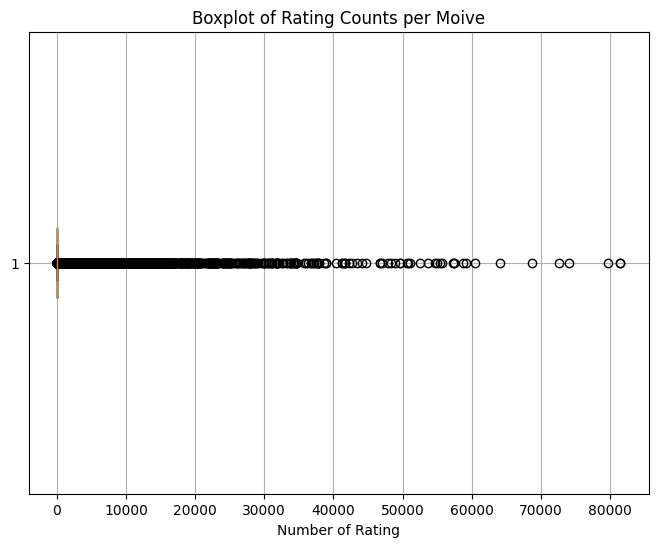

In [7]:
# Plot a box plot of rating counts
plt.figure(figsize = (8,6))
plt.boxplot(rating_counts, vert = False)
plt.title('Boxplot of Rating Counts per Moive')
plt.xlabel('Number of Rating')
plt.grid(True)
plt.show()

### Data preprocessing


#### Eliminate the timestamp column


Given that the timestamp for ratings serves no purpose, it will be removed.

In [8]:
#Copy the ratings_df
ratings_cleaned_df = ratings_df.copy()

# Remove the timestamp column
ratings_cleaned_df = ratings_df.drop(columns=['timestamp'])

# Check the head of ratings_cleaned_df
print(ratings_cleaned_df.head())

   userId  movieId  rating
0       1      296     5.0
1       1      306     3.5
2       1      307     5.0
3       1      665     5.0
4       1      899     3.5


#### Split the cloumns 'title' and '**genres**'

Given that the 'title' and 'genres' columns contain excessive information, we aim to divide the 'title' into two separate columns, one for the title itself and the other for the release year. Additionally, we will break down the 'genres' column into multiple columns, each representing a single genre and separated by a vertical line.

In [9]:
# Copy the movies_df
movies_cleaned_df = movies_df.copy()

# Splitting title into title and year columns
movies_cleaned_df[['title', 'year']] = movies_df['title'].str.extract(r'^(.*)\s?\((\d{4})\)\s*$')

# Check the head of merged_cleand_df
print(movies_cleaned_df.head())

# Check the shape of movies_cleaned_df
print(movies_cleaned_df.shape)

# Check the info of movies_cleaned_df
print(movies_cleaned_df.info())

# Check the describe of movies_cleaned_df
print(movies_cleaned_df.describe())

   movieId                         title  \
0        1                    Toy Story    
1        2                      Jumanji    
2        3             Grumpier Old Men    
3        4            Waiting to Exhale    
4        5  Father of the Bride Part II    

                                        genres  year  
0  Adventure|Animation|Children|Comedy|Fantasy  1995  
1                   Adventure|Children|Fantasy  1995  
2                               Comedy|Romance  1995  
3                         Comedy|Drama|Romance  1995  
4                                       Comedy  1995  
(62423, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62011 non-null  object
 2   genres   62423 non-null  object
 3   year     62011 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.9+ MB
None
         

To handle cases where the 'year' column contains values that cannot be directly converted to float, I can first attempt to convert the values to float. If conversion fails, I can then store the values for further exploration.

In [10]:
year_values = movies_cleaned_df['year']

# Initialize a list to store values that cannot be directly converted to int
non_int_values = []

# Iterate through the values of the column
for index, value in enumerate(year_values):
    try:
      # Try to convert the value to int
        int_value = np.int64(value)
    except ValueError:
      # If conversion to int fails, add the original 'title' value to the list
        non_int_values.append(movies_df.at[index,'title'])
    else:
      # If conversion succeeds, update the value in the movies_cleaned_df
      movies_cleaned_df.at[index, 'year'] = int_value

# Print the list of values that cannot be converted to int
print("Values that cannot be converted to int:", non_int_values)

Values that cannot be converted to int: ['Millions Game, The (Das Millionenspiel)', 'Mona and the Time of Burning Love (Mona ja palavan rakkauden aika) (1983))', 'Terrible Joe Moran', 'The Court-Martial of Jackie Robinson', 'In Our Garden', 'Stephen Fry In America - New World', 'Two: The Story of Roman & Nyro', 'A Year Along the Abandoned Road', 'Body/Cialo', 'Polskie gówno', 'The Third Reich: The Rise & Fall', 'La vendetta dei barbari', 'My Own Man', 'Moving Alan', 'Zone 261', 'Michael Laudrup - en Fodboldspiller', 'Honky', 'Blueberry Hill', 'Pleasure Palace', 'Terror on the 40th Floor', "My Boyfriend's Back", 'One Night Only', 'Doli Saja Ke Rakhna', 'The Dead Lands', "C'mon, Let's Live a Little", 'For a Book of Dollars', 'Twins from Texas', 'Señorita Justice', 'Flash and Firecat', 'Red Victoria', 'Vaastupurush', "Sierra Leone's Refugee All Stars", "L'uomo della carità", 'The Big Fall', 'Wolves In The Snow', 'Amazon Falls', 'Dark Tides', 'The Ritual', 'The Expedition', 'Chinese Boxes'

After adjusting our regular expression and inspecting the outcome of splitting the 'title' column into 'title' and 'year' columns, we noticed that some titles do not contain year information. Since this constitutes only a small portion of the data and for the sake of conducting a more precise analysis, we will proceed by removing the rows lacking year information.

In [11]:
movies_cleaned_df.drop(movies_cleaned_df[movies_cleaned_df['year'].isnull()].index, inplace=True)

In [12]:
# Convert the column to float
movies_cleaned_df['year'] = movies_cleaned_df['year'].astype(int)

# Check the head of merged_cleand_df
print(movies_cleaned_df.head())

# Check the shape of movies_cleaned_df
print(movies_cleaned_df.shape)

# Check the info of movies_cleaned_df
print(movies_cleaned_df.info())

# Check the describe of movies_cleaned_df
print(movies_cleaned_df.describe())

   movieId                         title  \
0        1                    Toy Story    
1        2                      Jumanji    
2        3             Grumpier Old Men    
3        4            Waiting to Exhale    
4        5  Father of the Bride Part II    

                                        genres  year  
0  Adventure|Animation|Children|Comedy|Fantasy  1995  
1                   Adventure|Children|Fantasy  1995  
2                               Comedy|Romance  1995  
3                         Comedy|Drama|Romance  1995  
4                                       Comedy  1995  
(62011, 4)
<class 'pandas.core.frame.DataFrame'>
Index: 62011 entries, 0 to 62422
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62011 non-null  int64 
 1   title    62011 non-null  object
 2   genres   62011 non-null  object
 3   year     62011 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.4+ MB
None
             m

In [13]:
# Extract distinct genres
distinct_genres = set()
for genres in movies_cleaned_df['genres']:
    distinct_genres.update(genres.split('|'))

# Create new columns for each distinct genre
for genre in distinct_genres:
  if genre != 'no genres listed)':
    movies_cleaned_df[genre] = movies_cleaned_df['genres'].apply(lambda x: 1 if genre in x else 0)

# Drop the original 'genres' column
movies_cleaned_df = movies_cleaned_df.drop(columns=['genres'])

# Check the head of movies_cleaned_df
print(movies_cleaned_df.head())

   movieId                         title  year  Sci-Fi  Documentary  Musical  \
0        1                    Toy Story   1995       0            0        0   
1        2                      Jumanji   1995       0            0        0   
2        3             Grumpier Old Men   1995       0            0        0   
3        4            Waiting to Exhale   1995       0            0        0   
4        5  Father of the Bride Part II   1995       0            0        0   

   Action  Romance  Drama  (no genres listed)  ...  Crime  War  Film-Noir  \
0       0        0      0                   0  ...      0    0          0   
1       0        0      0                   0  ...      0    0          0   
2       0        1      0                   0  ...      0    0          0   
3       0        1      1                   0  ...      0    0          0   
4       0        0      0                   0  ...      0    0          0   

   Children  Horror  Comedy  Fantasy  Western  Adventure

#### Merge the cleaned data

Due to the large size of the dataset, I'll be working with a subset of 5,000 users' records for my upcoming tasks.

In [14]:
# Identity unique user IDs
unique_user_ids = ratings_cleaned_df['userId'].unique()

# Print the number of unique user IDs
print("Number of unique user IDs:", len(unique_user_ids))

# Randomly sample 5000 user IDs
sampled_user_ids = np.random.choice(unique_user_ids, size=5000, replace=False)

# Filter the ratings_cleaned_df to include only the sampled user IDs
ratings_sample = ratings_cleaned_df[ratings_cleaned_df['userId'].isin(sampled_user_ids)]

# Check the head of ratings_sample
print(ratings_sample.head())

# Check the shape of the ratings_sample
print(ratings_sample.shape)

Number of unique user IDs: 162541
      userId  movieId  rating
2893      15      110     3.0
2894      15      141     5.0
2895      15      216     4.0
2896      15      296     5.0
2897      15      349     5.0
(750151, 3)


In [15]:
# merge the ratings_sample and movies_cleaned_df
merged_cleaned_df = pd.merge(ratings_sample, movies_cleaned_df, on='movieId')

# Check the head of merged_df
print(merged_cleaned_df.head())

   userId  movieId  rating        title  year  Sci-Fi  Documentary  Musical  \
0      15      110     3.0  Braveheart   1995       0            0        0   
1      95      110     4.5  Braveheart   1995       0            0        0   
2     122      110     3.0  Braveheart   1995       0            0        0   
3     241      110     3.5  Braveheart   1995       0            0        0   
4     313      110     3.0  Braveheart   1995       0            0        0   

   Action  Romance  ...  Crime  War  Film-Noir  Children  Horror  Comedy  \
0       1        0  ...      0    1          0         0       0       0   
1       1        0  ...      0    1          0         0       0       0   
2       1        0  ...      0    1          0         0       0       0   
3       1        0  ...      0    1          0         0       0       0   
4       1        0  ...      0    1          0         0       0       0   

   Fantasy  Western  Adventure  Mystery  
0        0        0       

#### Split the data

To ensure more accurate model evaluation, I will employ the leave-one-out strategy to split the training and testing subsets based on user_id.

In [16]:
# Filter users with more than one interaction
user_interaction_counts = merged_cleaned_df['userId'].value_counts()
users_with_multiple_interactions = user_interaction_counts[user_interaction_counts > 1].index

# Initialize lists to hold the training and testing data
training_data_list = []
testing_data_list = []

# Apply leave-one-out for each user with more than one interaction
for user_id in users_with_multiple_interactions:
    user_data = merged_cleaned_df[merged_cleaned_df['userId'] == user_id]

# Split the data into training and testing sets (one interaction as test set, rest as train set)
    user_train, user_test = train_test_split(user_data, test_size=1, random_state=2024)

# Append the training and testing data to the respective lists
    training_data_list.append(user_train)
    testing_data_list.append(user_test)

# Concatenate the training and testing data for each user
training_data = pd.concat(training_data_list)
testing_data = pd.concat(testing_data_list)

# Check the shape of the subsets
print(training_data.shape)
print(testing_data.shape)

# Check the head of the subsets
print(training_data.head(n=10))
print(testing_data.head(n=10))

(744785, 25)
(5000, 25)
        userId  movieId  rating                                  title  year  \
451191   17783     1263     5.0                      Deer Hunter, The   1978   
727207   17783   116704     3.5                               Zanjeer   1973   
542196   17783    78088     3.5                                Buried   2010   
584423   17783     3198     3.5                              Papillon   1973   
649533   17783     2247     3.0                    Married to the Mob   1988   
723501   17783     3533     2.5  Actor's Revenge, An (Yukinojô henge)   1963   
726620   17783    80810     3.5              Twilight's Last Gleaming   1977   
726477   17783    71404     3.0             3 Worlds of Gulliver, The   1960   
413428   17783   111362     3.5            X-Men: Days of Future Past   2014   
725117   17783     8335     4.0                 Make Way for Tomorrow   1937   

        Sci-Fi  Documentary  Musical  Action  Romance  ...  Crime  War  \
451191       0       

## Supervised Models

I'll generate multiple random forest regressor models, each with different hyperparameters specified in a grid for tunning. Then, I'll evaluate the RMSE of each model to determine the best-performing one.

In [17]:
# Select features and target variable
X_train = training_data.drop(columns=['rating','title']) # Features (excluding the 'rating' and 'title' columns)
y_train = training_data['rating'] # Target variable

X_test = testing_data.drop(columns=['rating','title']) # Features (excluding the 'rating' and 'title' columns)
y_test = testing_data['rating'] # Target variable

# Initialize RandomForestRegressor model
rf_model = RandomForestRegressor(random_state=2024)

# Define hyperparameters grid for tuning
param_grid = {
    'n_estimators': [10,50,100],
    'max_depth': [10,25,50]
}

# Initialize GridSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(rf_model, param_distributions=param_grid, cv=3, n_iter = 5, scoring='neg_root_mean_squared_error', random_state=2024)

# Train the model with hyperparameter tuning
random_search.fit(X_train, y_train)

# Print the random search results
print("Random Search Results:")
for params, mean_score in zip(random_search.cv_results_['params'], random_search.cv_results_['mean_test_score']):
    print(f"Params: {params}, Mean Score: {mean_score}")

# Get the best parameters
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# Initialize RandomForestRegressor model with the best parameters
best_rf_model = RandomForestRegressor(**best_params, random_state=2024)

# Train the model with the best parameters
best_rf_model.fit(X_train, y_train)

# Predict ratings for test set
y_pred = best_rf_model.predict(X_test)

# Calculate RMSE
rf_test_rmse = mean_squared_error(y_test, y_pred, squared=False)

print("Random Forest Test RMSE:", rf_test_rmse)

Random Search Results:
Params: {'n_estimators': 50, 'max_depth': 25}, Mean Score: -1.050429724891209
Params: {'n_estimators': 50, 'max_depth': 10}, Mean Score: -1.0218388485683236
Params: {'n_estimators': 50, 'max_depth': 50}, Mean Score: -1.1291446869782786
Params: {'n_estimators': 100, 'max_depth': 25}, Mean Score: -1.0484775747023696
Params: {'n_estimators': 10, 'max_depth': 25}, Mean Score: -1.0662414890500862
Best Parameters: {'n_estimators': 50, 'max_depth': 10}
Random Forest Test RMSE: 1.0312448955406361


## Unsupervised Models

Also I will create unsupervised model using NMF(Non-negative Matrix Factorization) and compare its performance with a supervised model like RandomForestRegressor.

In [20]:
# Create a user-item matrix
user_item_matrix = merged_cleaned_df.pivot_table(index='userId', columns='movieId', values='rating')

# Fill missing values with 0
user_item_matrix = user_item_matrix.fillna(0)

# Define a function to evaluate the NMF model
def evaluate_nmf(n_components, max_iter = 1500):
  nmf_model = NMF(n_components=n_components, init='random', max_iter=max_iter, random_state=2024)
  W = nmf_model.fit_transform(user_item_matrix)
  H = nmf_model.components_
  user_item_matrix_reconstructed = np.dot(W, H)
  user_item_reconstructed_df = pd.DataFrame(user_item_matrix_reconstructed, index=user_item_matrix.index, columns=user_item_matrix.columns)
  nmf_predictions = [user_item_reconstructed_df.loc[row['userId'], row['movieId']] for _, row in testing_data.iterrows()]
  nmf_test_rmse = mean_squared_error(y_test, nmf_predictions, squared=False)
  return nmf_test_rmse

# Perform grid search for the best n_components
n_components_range = [50,100,250]
nmf_rmse_scores = {n: evaluate_nmf(n) for n in n_components_range}

# Print the RMSE scores for each n_components value
for n, rmse in nmf_rmse_scores.items():
  print(f"NMF with {n} components: {rmse}")

# Get the best n_components value
best_n_components = min(nmf_rmse_scores, key=nmf_rmse_scores.get)
print(f"Best NMF with {best_n_components} components")

# Initialize NMF model with the best n_components
nmf_model = NMF(n_components=best_n_components, init='random', max_iter = 1500, random_state=2024)
W = nmf_model.fit_transform(user_item_matrix)
H = nmf_model.components_

# Reconstruct the user-item matrix
user_item_matrix_reconstructed = np.dot(W, H)
user_item_reconstructed_df = pd.DataFrame(user_item_matrix_reconstructed, index=user_item_matrix.index, columns=user_item_matrix.columns)

# Predict ratings for the testing subsets
nmf_predictions = [user_item_reconstructed_df.loc[row['userId'], row['movieId']] for _, row in testing_data.iterrows()]

# Calculate RMSE for the unsupervised model
nmf_test_rmse = mean_squared_error(y_test, nmf_predictions, squared=False)
print("NMF Test RMSE:", nmf_test_rmse)

NMF with 50 components: 2.9158879946440686
NMF with 100 components: 2.8152918357992904
NMF with 250 components: 2.6289870227250782
Best NMF with 250 components
NMF Test RMSE: 2.6289870227250782


## Conclusion


Based on our evaluation method, we found that the supervised model outperformed the unsupervised model, although both models required significant computation time. Additionally, the NMF model (unsupervised) struggled due to the limited dataset size and its inability to incorporate the release year and genres columns. Consequently, the NMF model's performance was suboptimal. Given the opportunity, we hope to utilize a more robust environment with a larger dataset to better compare the efficiency of the two models.